#### Library

In [1]:
import warnings
warnings.filterwarnings('ignore')  

import torch 
import torchvision 
import torchvision.transforms as T 
import torchvision.utils as vutils 
from PIL import Image 
import json 
import matplotlib.pyplot as plt 
import requests  
import os 
import numpy as np 
import random
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

In [2]:
# seed 고정

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Class list import
!curl -O https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31565  100 31565    0     0  1261k      0 --:--:-- --:--:-- --:--:-- 1284k


In [5]:
labels_map = json.load(open('labels_map.txt'))
labels_map

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '3': 'tiger shark, Galeocerdo cuvieri',
 '4': 'hammerhead, hammerhead shark',
 '5': 'electric ray, crampfish, numbfish, torpedo',
 '6': 'stingray',
 '7': 'cock',
 '8': 'hen',
 '9': 'ostrich, Struthio camelus',
 '10': 'brambling, Fringilla montifringilla',
 '11': 'goldfinch, Carduelis carduelis',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '13': 'junco, snowbird',
 '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 '15': 'robin, American robin, Turdus migratorius',
 '16': 'bulbul',
 '17': 'jay',
 '18': 'magpie',
 '19': 'chickadee',
 '20': 'water ouzel, dipper',
 '21': 'kite',
 '22': 'bald eagle, American eagle, Haliaeetus leucocephalus',
 '23': 'vulture',
 '24': 'great grey owl, great gray owl, Strix nebulosa',
 '25': 'European fire salamander, Salamandra salamandra',
 '26': 'common newt, Triturus vulga

#### Image import

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60067  100 60067    0     0   183k      0 --:--:-- --:--:-- --:--:--  183k


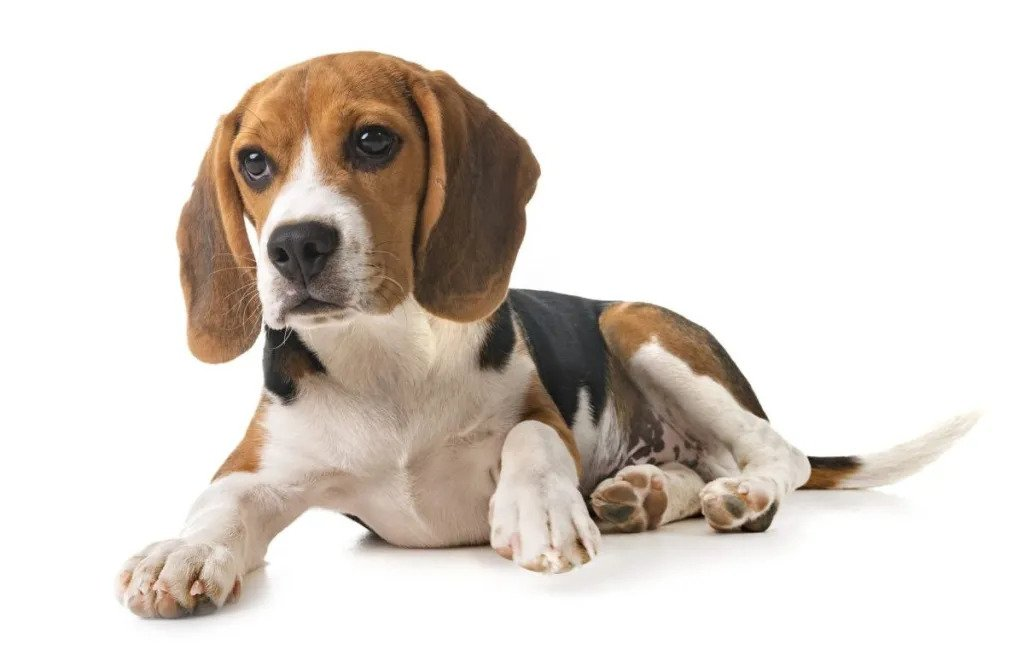

In [6]:
# 강아지 이미지 불러오기
!curl -O https://raw.githubusercontent.com/BupyeongHealer/sample-image/3ae2ccdf8eb1238c68e35149d24e164d8b7e8a40/dog.jpg

raw_img = Image.open('dog.jpg')
raw_img

#### Image Preprocessing

In [ ]:
image_size = 224

img_transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = img_transform(raw_img)
img_trans = img.unsqueeze(0) # (B, C, H, W) 변환

print(f"Original image size: {img.shape}")
print(f"Transform image size: {img_trans.shape}")

Original image size: torch.Size([3, 224, 224])
Transform image size: torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


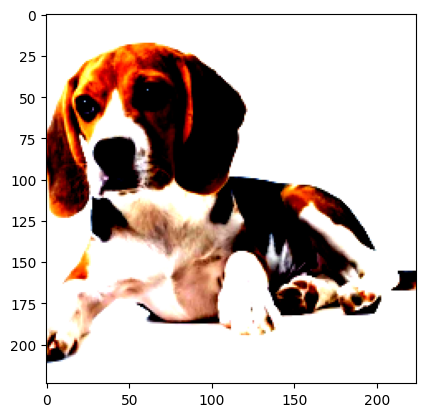

In [8]:
# 전처리 후 이미지
plt.imshow(img.squeeze(0).permute(1,2,0))

#### EfficientNet Model

In [9]:
# EfficientNet import
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model = model.to(device)
model

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /Users/mungughyeon/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /Users/mungughyeon/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 7.89MB/s]


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [11]:
# inference
model.eval()  
with torch.no_grad(): # 그라디언트 계산 비활성화
    logits = model(img_trans.to(device))

print('logits 텐서 사이즈:', logits.shape)
logits[0][:10]  # 10번째 클래스까지 logit 보기

logits 텐서 사이즈: torch.Size([1, 1000])


tensor([ 0.1310, -0.0286, -1.2836, -0.9350,  0.0218,  0.6607, -0.6541, -0.4369,
        -0.5568,  0.3513])

In [12]:
# 예측한 logits의 클래스 인덱스
preds = torch.topk(logits, k=5).indices # TOP5 Class index 추출
preds = preds.squeeze()

# softmax를 이용한 클래스 별 예측 확률
for idx in preds:
    label = labels_map[str(idx.item())]  # 레이블 데이터에서 인덱스로 레이블 매칭
    prob = torch.softmax(logits, dim=1)[0, idx].item()  # softmax 계산
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

beagle                                                                      (36.26%)
English foxhound                                                            (19.80%)
Walker hound, Walker foxhound                                               (17.33%)
bluetick                                                                    (0.98%)
basset, basset hound                                                        (0.85%)


In [14]:
!mkdir -p ../data/coco_imgs

!curl -o ../data/coco_imgs/COCO_val2014_000000000073.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000000073.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000000285.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000000285.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000000397.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000000397.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000000827.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000000827.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000001448.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000001448.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000002753.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000002753.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000006211.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000006211.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000018893.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000018893.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000038355.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000038355.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000041276.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000041276.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000050124.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000050124.jpg
!curl -o ../data/coco_imgs/COCO_val2014_000000053503.jpg http://images.cocodataset.org/val2014/COCO_val2014_000000053503.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  374k  100  374k    0     0   311k      0  0:00:01  0:00:01 --:--:--  311k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k  100  327k    0     0   265k      0  0:00:01  0:00:01 --:--:--  265k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313k  100  313k    0     0   253k      0  0:00:01  0:00:01 --:--:--  253k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  183k  100  183k    0     0   170k      0  0:00:01  0:00:01 --:--:--  171k
  % Total    % Received % Xferd  Average Speed   Tim

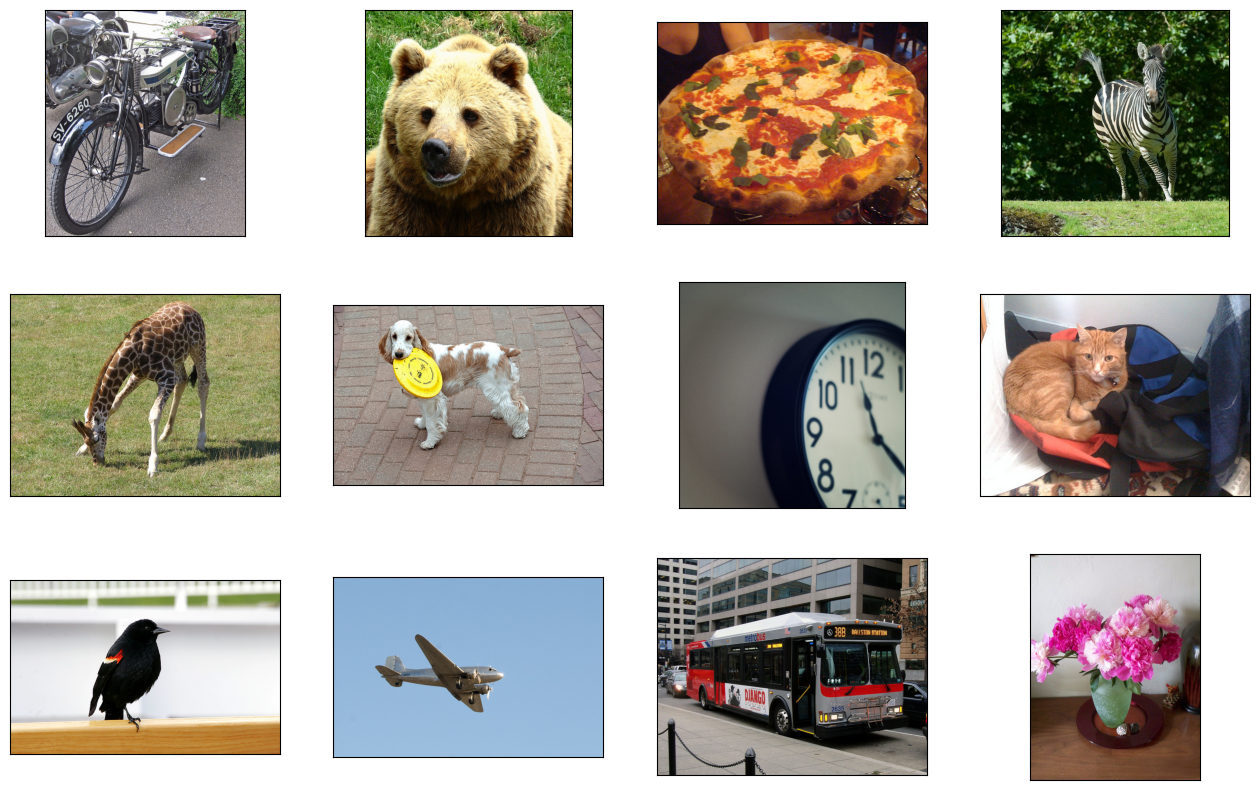

In [16]:
# 이미지 파일 리스트
dataset_dir = '../data/coco_imgs/'
img_file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')] # 해당 폴더 아래에 .jpg 확장자로 된 파일들 취합
img_file_list.sort()


plt.figure(figsize=(16,10))
for i, f in enumerate(img_file_list):
  plt.subplot(3,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = Image.open(dataset_dir+f)
  plt.imshow(img)
plt.show()

In [17]:
# Image Preprocessing
image_size = 224

img_transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Image Batch
images = []
for f in img_file_list:
    img = Image.open(dataset_dir+f)
    img = img_transform(img) # transform
    images.append(np.array(img))

images = torch.tensor(images)
print(f"Tensor size:{images.shape}")


Tensor size:torch.Size([12, 3, 224, 224])


In [18]:
# inference
model.eval()
with torch.no_grad():
    logits = model(images.to(device))
print(f"logits size:{logits.shape}")

preds = torch.topk(logits, k=5).indices
labels_list = [labels_map[str(i)] for i in range(len(labels_map.keys()))]
labels_list

logits size:torch.Size([12, 1000])


['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

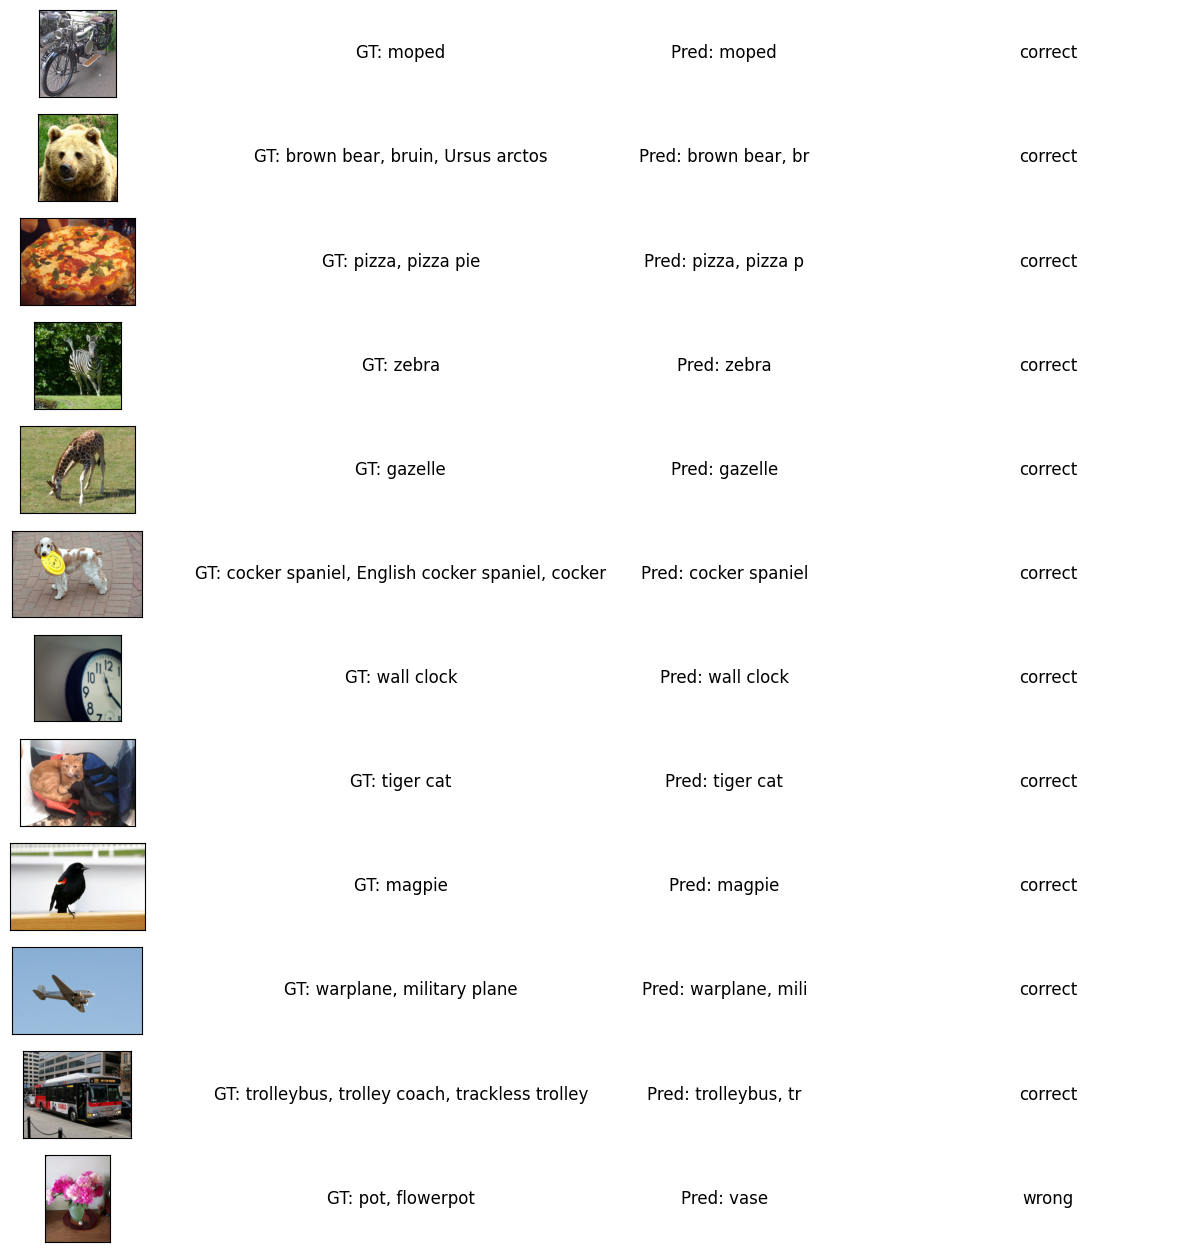

정확도 91.67%


In [ ]:
# ground truth 레이블
ground_truth = [
    665, # 'moped'
    294, # 'brown bear, bruin, Ursus arctos
    963, # 'pizza, pizza pie
    340, # 'zebra
    353, # 'gazelle
    219, # 'cocker spaniel, English cocker spaniel, cocker
    892, # 'wall clock
    282, # 'tiger cat
    18,  # 'magpie
    895, # 'warplane, military plane
    874, # 'trolleybus, trolley coach, trackless trolley
    738 # 'pot, flowerpot
  ]

ground_truth_label = [
    'moped',
    'brown bear, bruin, Ursus arctos',
    'pizza, pizza pie',
    'zebra',
    'gazelle',
    'cocker spaniel, English cocker spaniel, cocker',
    'wall clock',
    'tiger cat',
    'magpie',
    'warplane, military plane',
    'trolleybus, trolley coach, trackless trolley',
    'pot, flowerpot'
]

# 예측 결과
prediction = preds[:, 0] # .cpu()
labels_preds = prediction.tolist()
label_preds = [labels_map[str(label)][:14] for label in labels_preds]

answer = []
if len(prediction) == len(ground_truth):
    for pred, gt in zip(prediction, ground_truth):
        if pred == gt:
            answer.append("correct")
        else:
            answer.append("wrong")


plt.figure(figsize=(16,16))

for i, (f, pred) in enumerate(zip(img_file_list, preds)):
    # 입력 이미지
    plt.subplot(12,4,i*4+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(dataset_dir+f)
    plt.imshow(img)
    # Ground Truth
    plt.subplot(12,4,i*4+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, f"GT: {ground_truth_label[i]}", fontsize=12, ha='center', va='center')
    plt.axis('off')
    # Prediction
    plt.subplot(12,4,i*4+3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, f"Pred: {label_preds[i]}", fontsize=12, ha='center', va='center')
    plt.axis('off')
    # 정답 여부
    plt.subplot(12,4,i*4+4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, answer[i], fontsize=12, ha='center', va='center')
    plt.axis('off')
plt.show()

# 정확도(Accuracy) 계산
acc = prediction.eq(torch.tensor(ground_truth)).sum() / len(ground_truth)
print('정확도 {:.2f}%'.format(acc.item() * 100))

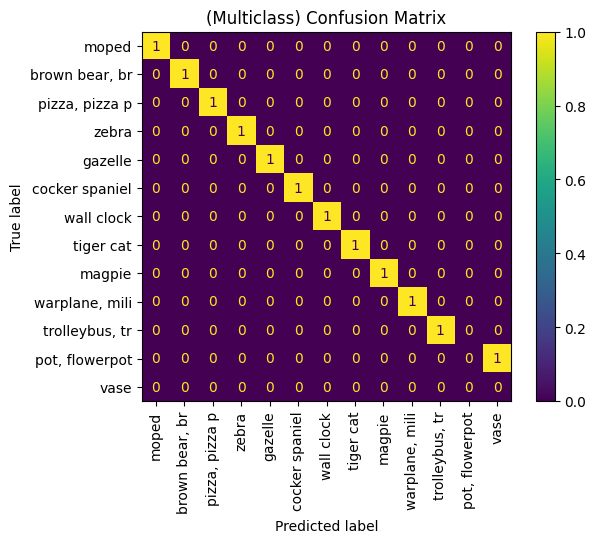

In [21]:
set_preds = set(prediction.tolist())
set_diff = list(set_preds.difference(ground_truth))
labels = ground_truth + set_diff
label_names = [labels_map[str(label)][:14] for label in labels]

# confusion matrix 계산
cf_mat = confusion_matrix(ground_truth, prediction, labels=labels)

# confusion matrix 시각화
ConfusionMatrixDisplay(cf_mat).plot()
plt.xticks(ticks=[*range(len(labels))], labels=label_names, rotation=90)
plt.yticks(ticks=[*range(len(labels))], labels=label_names)
plt.title('(Multiclass) Confusion Matrix')
plt.show()